In [1]:
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import requests
import torch 
import matplotlib.pyplot as plt
import cv2
import numpy as np
# from img_utils import get_pyx_prime, get_heatmap, plot_overlap_np

/opt/crc/c/conda/23.5.2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [29]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# url = "http://farm1.staticflickr.com/50/150324104_97d2122a44_z.jpg"
url = "http://farm2.staticflickr.com/1342/1342680003_e85c0c76a3_z.jpg"
# url = "http://farm3.staticflickr.com/2066/1798910782_5536af8767_z.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True)

outputs = model(output_attentions=True, output_hidden_states=True, **inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  

In [30]:
print(outputs.vision_model_output.last_hidden_state.shape)
print(outputs.text_model_output.last_hidden_state.shape)
print(outputs.keys())
print(probs)
print(outputs.vision_model_output.keys())

torch.Size([1, 197, 768])
torch.Size([2, 7, 512])
odict_keys(['logits_per_image', 'logits_per_text', 'text_embeds', 'image_embeds', 'text_model_output', 'vision_model_output'])
tensor([[0.3245, 0.6755]], grad_fn=<SoftmaxBackward0>)
odict_keys(['last_hidden_state', 'pooler_output', 'hidden_states', 'attentions'])


In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_pyx_prime(model, outputs):
    """
    Obtain p(y|x) and p(y|x'), where x' is the input with the ith entry missing.
    Args:
        model: a CLIP model
        outputs: the outputs of the CLIP model given input x
    Returns:
        pyx: p(y|x)
        pyx_prime: p(y|x')
    """
    text_embeds = outputs.text_embeds # [N_t, d]
    image_embeds = outputs.vision_model_output.last_hidden_state # [N_v, L+1, d']
    image_embeds = model.vision_model.post_layernorm(image_embeds)
    image_embeds = model.visual_projection(image_embeds) #[N_v, L+1, d]

    text_embeds = text_embeds.unsqueeze(0).unsqueeze(0) # [1, 1, N_t, d]
    image_embeds = image_embeds.unsqueeze(2) # [N_v, L+1, 1, d]
    # text_embeds = text_embeds[:, 0:1, :] - text_embeds + 1e-5

    # normalized features
    image_embeds = image_embeds / image_embeds.norm(p=2, dim=-1, keepdim=True)
    text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)

    logit_scale = model.logit_scale.exp()
    logits_per_image = (image_embeds * text_embeds).sum(-1) * logit_scale # [N_v, L+1, N_t]

    # probs_per_image = torch.softmax(logits_per_image, dim=-1)
    probs_per_image = logits_per_image

    pyx = probs_per_image[:, 0:1, :] # [N_v, 1, N_t]
    pyx_prime = probs_per_image[:, 1:, :] # [N_v, L, N_t]
    return pyx, pyx_prime

def get_heatmap(pyx, pyx_prime):
    """
    Given p(y|x) and p(y|x'), where x' is the input with the ith entry missing.
    Args:
        pyx: [N_v, 1, N_t]
        pyx_prime: [N_v, L, N_t]

    Returns: 
        heatmap: [N_v, 14, 14, N_t]
    """
    res = (pyx - pyx_prime) # [N_v, L, N_t]
    # res = pyx_prime
    N_v, L, N_t = res.shape
    # res = (res>0).float() * res
    
    heatmap = res.reshape(N_v,14,14, N_t).detach().cpu().numpy()
    return heatmap

def unnormalize(img, mean, std):
    mean = np.array(mean).reshape(1,1,3)
    std = np.array(std).reshape(1,1,3)
    return img * std + mean

def convert_to_255_scale(img):
    return (img * 255).astype(np.uint8)

def unnormalize_and_255_scale(img, mean, std):
    return convert_to_255_scale(unnormalize(img,mean,std))

def show_superimposed(img, heatmap):
    cv2_image = cv2.cvtColor(img.transpose(1,2,0), cv2.COLOR_RGB2BGR)
    blur = cv2.GaussianBlur(heatmap,(13,13), 11)

def normalize_and_rescale(heatmap):
    max_value = np.max(heatmap)
    min_value = np.min(heatmap)
    heatmap_ft = (heatmap - min_value) / (max_value - min_value) # float point
    return convert_to_255_scale(heatmap_ft) # int8

def get_overlap(image, heatmap):
    return cv2.addWeighted(heatmap, 0.5, image, 0.5, 0)

def plot_overlap(image, heatmap):
    overlap = get_overlap(image, heatmap)
    plt.imshow(overlap)
    plt.axis('off')
    plt.show()
    return 0

def plot_overlap_np(image, heatmap, img_mean, img_std):
    shape = image.shape[:2]
    heatmap = normalize_and_rescale(heatmap)
    resized_heatmap = cv2.resize(heatmap, shape)
    blur = cv2.blur(resized_heatmap ,(13,13), 11)
    heatmap_img = cv2.applyColorMap(blur, cv2.COLORMAP_JET)
    heatmap_img = cv2.cvtColor(heatmap_img, cv2.COLOR_BGR2RGB)

    image = unnormalize_and_255_scale(image, img_mean, img_std)
    
    plot_overlap(image, heatmap_img)
    return image, heatmap_img

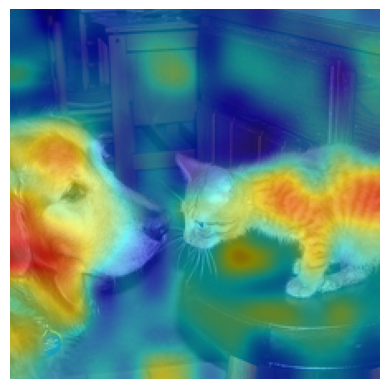

In [35]:
pyx, pyx_prime = get_pyx_prime(model, outputs)
heatmap = get_heatmap(pyx, pyx_prime)
heatmap = heatmap[0,:,:,1]
    
# get mean and std to unnormalize the processed images
mean, std = processor.image_processor.image_mean, processor.image_processor.image_std

img = inputs.pixel_values[0].numpy().transpose(1,2,0)
image, heatmap_img = plot_overlap_np(img, heatmap, mean, std)

In [33]:
pyx_prime

tensor([[[25.6921, 27.0906],
         [27.5794, 30.2006],
         [25.6502, 27.1431],
         [26.8442, 28.0240],
         [25.2517, 27.5779],
         [24.1802, 27.1577],
         [25.1279, 27.1323],
         [25.3670, 28.2629],
         [25.6481, 27.6242],
         [27.7020, 28.6355],
         [27.0349, 27.1583],
         [25.8438, 27.3353],
         [25.2831, 26.3614],
         [26.9467, 27.5204],
         [26.1122, 27.5568],
         [24.4623, 26.5047],
         [26.5714, 28.5908],
         [25.6780, 28.9669],
         [23.9004, 27.0064],
         [23.0134, 25.2206],
         [23.3310, 25.9443],
         [26.4211, 28.9222],
         [25.1769, 25.7892],
         [24.9379, 26.5089],
         [27.7843, 27.4655],
         [27.5385, 28.1129],
         [26.4314, 27.8543],
         [24.7998, 25.3622],
         [23.7280, 24.4125],
         [24.8820, 27.7380],
         [25.3345, 27.2097],
         [24.6566, 27.3796],
         [23.2428, 28.1609],
         [24.5054, 24.9721],
         [23.3

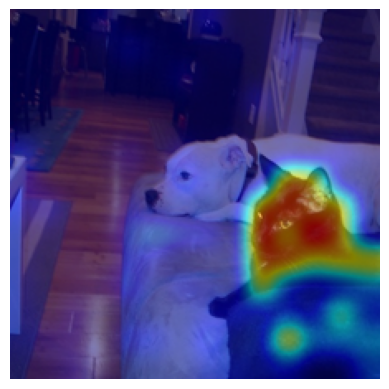

In [6]:
def get_pyx_prime(model, outputs):
    """
    Obtain p(y|x) and p(y|x'), where x' is the input with the ith entry missing.
    Args:
        model: a CLIP model
        outputs: the outputs of the CLIP model given input x
    Returns:
        pyx: p(y|x)
        pyx_prime: p(y|x')
    """
    text_embeds = outputs.text_embeds # [N_t, d]
    image_embeds = outputs.vision_model_output.last_hidden_state # [N_v, L+1, d']
    image_embeds = model.vision_model.post_layernorm(image_embeds)
    image_embeds = model.visual_projection(image_embeds) #[N_v, L+1, d]

    text_embeds = text_embeds.unsqueeze(0).unsqueeze(0) # [1, 1, N_t, d]
    image_embeds = image_embeds.unsqueeze(2) # [N_v, L+1, 1, d]

    # normalized features
    image_embeds = image_embeds / image_embeds.norm(p=2, dim=-1, keepdim=True)
    text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)

    logit_scale = model.logit_scale.exp()
    logits_per_image = (image_embeds * text_embeds).sum(-1) * logit_scale # [N_v, L+1, N_t]

    # probs_per_image = torch.softmax(logits_per_image, dim=-1)
    probs_per_image = logits_per_image

    pyx = probs_per_image[:, 0:1, :] # [N_v, 1, N_t]
    pyx_prime = probs_per_image[:, 1:, :] # [N_v, L, N_t]
    return pyx, pyx_prime

def get_heatmap(pyx, pyx_prime):
    """
    Given p(y|x) and p(y|x'), where x' is the input with the ith entry missing.
    Args:
        pyx: [N_v, 1, N_t]
        pyx_prime: [N_v, L, N_t]

    Returns: 
        heatmap: [N_v, 14, 14, N_t]
    """
    res = (pyx - pyx_prime) # [N_v, L, N_t]
    N_v, L, N_t = res.shape
    res = (res>0).float() * res
    
    heatmap = res.reshape(N_v,14,14, N_t).detach().cpu().numpy()
    return heatmap

def unnormalize(img, mean, std):
    mean = np.array(mean).reshape(1,1,3)
    std = np.array(std).reshape(1,1,3)
    return img * std + mean

def convert_to_255_scale(img):
    return (img * 255).astype(np.uint8)

def unnormalize_and_255_scale(img, mean, std):
    return convert_to_255_scale(unnormalize(img,mean,std))

def show_superimposed(img, heatmap):
    cv2_image = cv2.cvtColor(img.transpose(1,2,0), cv2.COLOR_RGB2BGR)
    blur = cv2.GaussianBlur(heatmap,(13,13), 11)

def normalize_and_rescale(heatmap):
    max_value = np.max(heatmap)
    min_value = np.min(heatmap)
    heatmap_ft = (heatmap - min_value) / (max_value - min_value) # float point
    return convert_to_255_scale(heatmap_ft) # int8

def get_overlap(image, heatmap):
    return cv2.addWeighted(heatmap, 0.5, image, 0.5, 0)

def plot_overlap(image, heatmap):
    overlap = get_overlap(image, heatmap)
    plt.imshow(overlap)
    plt.axis('off')
    plt.show()
    return 0

def plot_overlap_np(image, heatmap, img_mean, img_std):
    shape = image.shape[:2]
    heatmap = normalize_and_rescale(heatmap)
    resized_heatmap = cv2.resize(heatmap, shape)
    blur = cv2.blur(resized_heatmap ,(13,13), 11)
    heatmap_img = cv2.applyColorMap(blur, cv2.COLORMAP_JET)
    heatmap_img = cv2.cvtColor(heatmap_img, cv2.COLOR_BGR2RGB)

    image = unnormalize_and_255_scale(image, img_mean, img_std)
    
    plot_overlap(image, heatmap_img)
    return image, heatmap_img



pyx, pyx_prime = get_pyx_prime(model, outputs)
heatmap = get_heatmap(pyx, pyx_prime)
heatmap = heatmap[0,:,:,0]
    
# get mean and std to unnormalize the processed images
mean, std = processor.image_processor.image_mean, processor.image_processor.image_std

img = inputs.pixel_values[0].numpy().transpose(1,2,0)
image, heatmap_img = plot_overlap_np(img, heatmap, mean, std)


In [7]:
(pyx - pyx_prime).shape

torch.Size([1, 196, 2])

In [8]:
resized_heatmap = cv2.resize(cv2_heatmap, (224,224))
blur = cv2.blur(resized_heatmap ,(13,13), 11)
# blur =resized_heatmap

NameError: name 'cv2_heatmap' is not defined

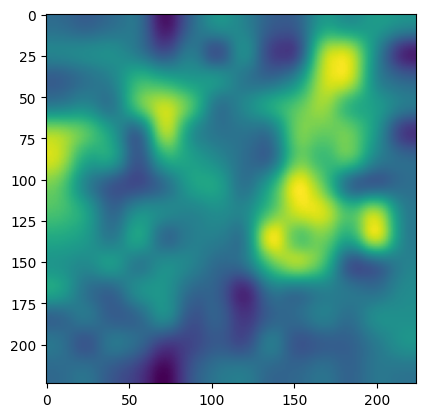

In [ ]:
plt.imshow(blur)

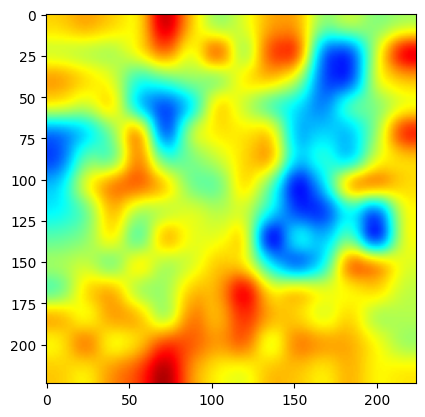

In [ ]:
heatmap_img = cv2.applyColorMap(blur, cv2.COLORMAP_JET)
plt.imshow(heatmap_img)

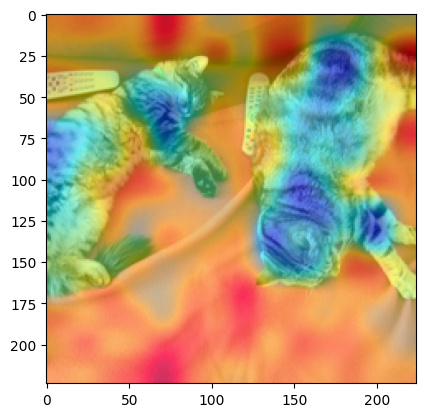

In [ ]:
from matplotlib.cm import ScalarMappable

super_imposed_img = cv2.addWeighted(heatmap_img, 0.5, img, 0.5, 0)
plt.imshow(super_imposed_img)
# plt.colorbar(img)

In [ ]:
heatmap_img.shape

(224, 224, 3)

### Ratio of p(y|x) and p(y|x') as heatmap

In [ ]:
def get_pyx_prime(model, outputs):
    """
    last_hidden_state: (N, L+1, d')
    """
    text_embeds = outputs.text_embeds # [N_t, d]
    image_embeds = outputs.vision_model_output.last_hidden_state # [N_v, L+1, d']
    image_embeds = model.vision_model.post_layernorm(image_embeds)
    image_embeds = model.visual_projection(image_embeds) #[N_v, L+1, d]

    text_embeds = text_embeds.unsqueeze(0).unsqueeze(0) # [1, 1, N_t, d]
    image_embeds = image_embeds.unsqueeze(2) # [N_v, L+1, 1, d]

    # normalized features
    image_embeds = image_embeds / image_embeds.norm(p=2, dim=-1, keepdim=True)
    text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)

    logit_scale = model.logit_scale.exp()
    logits_per_image = (image_embeds * text_embeds).sum(-1) #* logit_scale # [N_v, L+1, N_t]

    # probs_per_image = torch.softmax(logits_per_image, dim=-1)
    probs_per_image = logits_per_image

    pyx = probs_per_image[:, 0:1, :] # [N_v, 1, N_t]
    pyx_prime = probs_per_image[:, 1:, :] # [N_v, L, N_t]
    return pyx, pyx_prime

pyx, pyx_prime = get_pyx_prime(model, outputs)

    

In [ ]:
# res = (pyx[:,:,0] / pyx[:,:,1]) / (pyx_prime[:,:,0] / pyx_prime[:,:,1])
res = (pyx - pyx_prime)[:,:,0]
# res = (res>0).float() * res

In [ ]:
res

tensor([[-0.0393, -0.0467, -0.0396, -0.0313, -0.0828, -0.0402, -0.0172, -0.0291,
         -0.0461, -0.0466, -0.0148, -0.0267, -0.0154, -0.0219, -0.0246, -0.0215,
         -0.0194, -0.0355, -0.0569, -0.0261, -0.0659, -0.0128, -0.0623, -0.0671,
          0.0268,  0.0343, -0.0270, -0.0774, -0.0495, -0.0396, -0.0307, -0.0005,
         -0.0106, -0.0205, -0.0110, -0.0388, -0.0440, -0.0266,  0.0283,  0.0351,
         -0.0325, -0.0410, -0.0356, -0.0256, -0.0434,  0.0127,  0.0309,  0.0095,
         -0.0439, -0.0247, -0.0044,  0.0047,  0.0221, -0.0145, -0.0144, -0.0286,
          0.0215,  0.0105, -0.0149, -0.0587,  0.0373, -0.0290, -0.0376, -0.0358,
         -0.0421,  0.0145,  0.0055,  0.0126, -0.0178, -0.0687,  0.0286, -0.0152,
         -0.0054, -0.0566, -0.0048, -0.0146, -0.0262, -0.0385, -0.0515,  0.0096,
         -0.0086,  0.0142, -0.0300, -0.0376,  0.0080, -0.0338, -0.0542, -0.0583,
         -0.0450, -0.0117, -0.0088, -0.0428, -0.0126,  0.0442,  0.0071, -0.0547,
         -0.0575, -0.0387,  

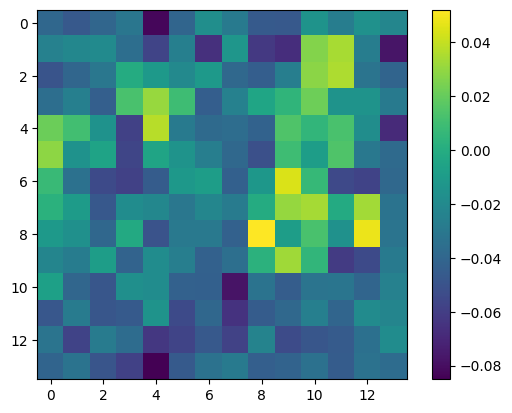

In [ ]:
plt.imshow(res[0].reshape(14,14).detach().cpu().numpy())
plt.colorbar()

In [ ]:
heatmap = res[0].reshape(14,14).detach().cpu().numpy()

In [ ]:
heatmap

array([[-0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
         0.02677356,  0.03433906, -0.        , -0.        ],
       [-0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
         0.02833425,  0.03510028, -0.        , -0.        ],
       [-0.        , -0.        , -0.        ,  0.01267293,  0.03086069,
         0.00947064, -0.        , -0.        , -0.        ,  0.00471146,
         0.02207287, -0.        , -0.        , -0.        ],
       [ 0.02145939,  0.01054202, -0.        , -0.        ,  0.03729971,
        -0.        , -0.        , -0.        , -0.        ,  0.01450835,
         0.0054937 ,  0.01

In [ ]:
mean, std = processor.image_processor.image_mean, processor.image_processor.image_std
# image = inputs.pixel_values[0].permute(1,2,0)
# plt.imshow(image)

# # Plot the heatmap as an overlay
# plt.imshow(res[0].reshape(14,14).detach().cpu().numpy(), alpha=0.0)
# # plt.colorbar(heatmap)

# # Show the plot
# plt.show()

In [ ]:
std

[0.26862954, 0.26130258, 0.27577711]

torch.Size([1, 3, 224, 224])

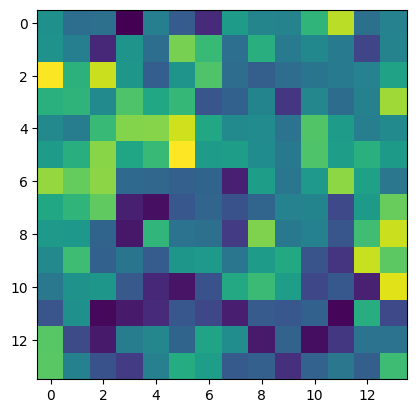

In [ ]:

def calculate_tv_sim(model, outputs):
    text_embeds = outputs.text_embeds # [N_t, d]
    vision_embeds = outputs.vision_model_output.last_hidden_state # [N_v, L+1, d']
    vision_embeds = model.vision_model.post_layernorm(vision_embeds)
    vision_embeds = model.visual_projection(vision_embeds) #[N_v, L+1, d]

    text_embeds = text_embeds.unsqueeze(1).unsqueeze(1)  #[N_t, 1, 1, d]
    vision_embeds = vision_embeds.unsqueeze(0) # [1, N_v, L+1, d]
    sim =  1 / text_embeds * vision_embeds # [N_t, N_v, L+1, d]
    return sim

def hm_sim_txt_vis(model, outputs):
    sim = calculate_tv_sim(model, outputs) # [N_t, N_v, L+1, d]
    sim = sim[:,:, 1:, :].sum(-1) # [N_t, N_v, L]
    N_t, N_v, _ = sim.shape
    
    return sim.reshape(N_t, N_v, 14, 14).detach().cpu().numpy()

hm = hm_sim_txt_vis(model, outputs)
plt.imshow(hm[0,0])

### Mean of hidden state dims as heatmap

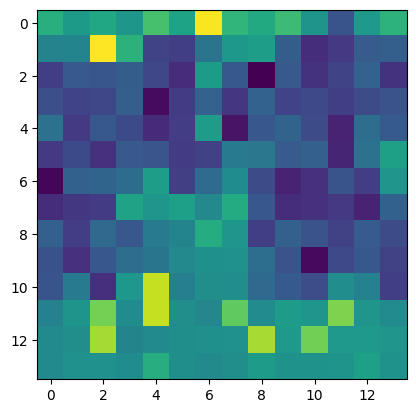

In [ ]:
def hm_mean_hidden_state(hidden_state):
    hidden_state = hidden_state[:,1:,:]
    mean_hidden_state = torch.mean(hidden_state, dim=-1)
    return mean_hidden_state.reshape(-1, 14, 14)

hm = hm_mean_hidden_state(outputs.vision_model_output.last_hidden_state.detach())
plt.imshow(hm[0])

### Similarity between texts and vision representations

In [ ]:
def calculate_tv_sim(model, outputs):
    text_embeds = outputs.text_embeds # [N_t, d]
    vision_embeds = outputs.vision_model_output.last_hidden_state # [N_v, L+1, d']
    vision_embeds = model.vision_model.post_layernorm(vision_embeds)
    vision_embeds = model.visual_projection(vision_embeds) #[N_v, L+1, d]

    text_embeds = text_embeds.unsqueeze(1).unsqueeze(1)  #[N_t, 1, 1, d]
    vision_embeds = vision_embeds.unsqueeze(0) # [1, N_v, L+1, d]
    sim =  text_embeds * vision_embeds # [N_t, N_v, L+1, d]
    return sim

def hm_sim_txt_vis(model, outputs):
    sim = calculate_tv_sim(model, outputs) # [N_t, N_v, L+1, d]
    sim = sim[:,:, 1:, :].sum(-1) # [N_t, N_v, L]
    N_t, N_v, _ = sim.shape
    
    return sim.reshape(N_t, N_v, 14, 14).detach().cpu().numpy()

hm = hm_sim_txt_vis(model, outputs)
plt.imshow(hm[0,0])
# calculate_tv_sim(model, outputs).shape

In [ ]:
def calculate_tv_max_pool(model, outputs):
    text_embeds = outputs.text_embeds # [N_t, d]
    vision_embeds = outputs.vision_model_output.last_hidden_state # [N_v, L+1, d']
    vision_embeds = model.vision_model.post_layernorm(vision_embeds)
    vision_embeds = model.visual_projection(vision_embeds) #[N_v, L+1, d]

    text_embeds = text_embeds.unsqueeze(1).unsqueeze(1)  #[N_t, 1, 1, d]
    vision_embeds = vision_embeds.unsqueeze(0) # [1, N_v, L+1, d]
    sim = text_embeds * vision_embeds # [N_t, N_v, L+1, d]
    sim = sim / sim.norm(p=2, dim=-1, keepdim=True)
    idices = torch.topk(sim.mean(-2), dim=-1, k=5)
    return sim, idices

def hm_sim_txt_vis(model, outputs):
    sim = calculate_tv_sim(model, outputs) # [N_t, N_v, L+1, d]
    sim = sim[:,:, 1:, :].sum(-1) # [N_t, N_v, L]
    N_t, N_v, _ = sim.shape
    
    return sim.reshape(N_t, N_v, 14, 14).detach().cpu().numpy()

sim, idices = calculate_tv_max_pool(model, outputs)


In [ ]:
print(sim.shape)
print(idices)

torch.Size([2, 1, 197, 512])
torch.return_types.topk(
values=tensor([[[0.7520, 0.6365, 0.0220, 0.0203, 0.0170]],

        [[0.7460, 0.6464, 0.0214, 0.0190, 0.0165]]], grad_fn=<TopkBackward0>),
indices=tensor([[[362, 442, 350, 376, 206]],

        [[362, 442, 350, 280, 376]]]))


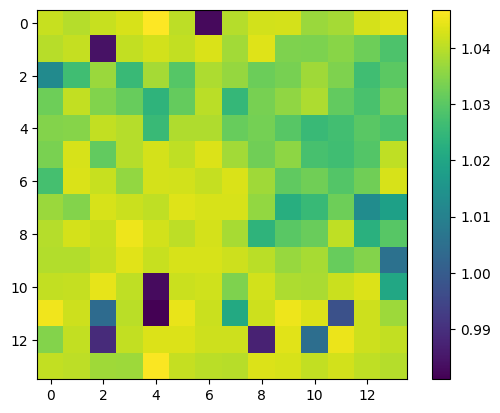

In [ ]:
new_sim = sim[0,0, 1:, 362] * 0.7520 + sim[0,0, 1:, 442] * 0.7365 + sim[0,0, 1:, 350] * 0.0220

plt.imshow(new_sim.reshape(14,14).detach().cpu().numpy())
plt.colorbar()

In [ ]:
sim[0,0, 1:, 362].reshape(14,14)

tensor([[0.7472, 0.7637, 0.7666, 0.7462, 0.7109, 0.7635, 0.4540, 0.7721, 0.7549,
         0.7523, 0.7816, 0.7658, 0.7328, 0.7336],
        [0.7531, 0.7635, 0.4573, 0.7462, 0.7404, 0.7646, 0.7412, 0.7729, 0.7211,
         0.7620, 0.7965, 0.7844, 0.7928, 0.7958],
        [0.8492, 0.7904, 0.7618, 0.8113, 0.7627, 0.8019, 0.7358, 0.7635, 0.7692,
         0.8020, 0.7802, 0.7950, 0.8116, 0.8019],
        [0.8026, 0.7547, 0.7794, 0.8002, 0.8093, 0.7834, 0.7502, 0.7746, 0.7931,
         0.7857, 0.7719, 0.8047, 0.8136, 0.7948],
        [0.7854, 0.7825, 0.7668, 0.7500, 0.8167, 0.7563, 0.7441, 0.7677, 0.7931,
         0.8082, 0.8248, 0.8175, 0.8100, 0.8118],
        [0.7819, 0.7530, 0.8097, 0.7627, 0.7496, 0.7652, 0.7435, 0.7665, 0.7926,
         0.7841, 0.8163, 0.8165, 0.8035, 0.7489],
        [0.8092, 0.7448, 0.7482, 0.7845, 0.7513, 0.7487, 0.7560, 0.7367, 0.7715,
         0.8032, 0.7965, 0.8023, 0.7897, 0.7272],
        [0.7730, 0.7820, 0.7249, 0.7159, 0.7353, 0.7269, 0.7387, 0.7055, 0.7732,
  

In [ ]:
vision_embeds[0,0, 1:, 362].reshape(14,14)

tensor([[1.0162, 0.9825, 1.0411, 1.0292, 1.0284, 1.0181, 0.6500, 1.0254, 1.0341,
         1.0373, 1.0390, 1.0202, 1.0857, 1.0445],
        [1.0539, 1.0401, 0.6553, 1.0386, 1.0785, 1.0352, 1.0808, 0.9885, 1.0285,
         0.9393, 0.9859, 0.9889, 1.0034, 0.9200],
        [0.9735, 0.8674, 0.8955, 0.9778, 0.9777, 0.9894, 0.9561, 0.9135, 0.8735,
         0.9808, 0.9588, 0.9807, 0.9749, 0.9627],
        [1.0075, 1.0119, 1.0125, 0.9639, 0.9163, 0.9200, 0.9737, 0.8102, 1.0201,
         0.9511, 0.9766, 1.0157, 0.9829, 0.9399],
        [0.9660, 0.9903, 1.0171, 0.9501, 0.9500, 0.9033, 1.0131, 0.8848, 1.0065,
         0.9768, 0.9662, 0.9909, 0.9944, 0.9570],
        [0.9424, 1.0344, 0.9885, 0.9694, 1.0214, 1.0024, 0.9893, 0.9305, 0.9827,
         0.9940, 1.0147, 0.9680, 0.9774, 1.0256],
        [0.9233, 1.0920, 0.9941, 1.0098, 1.1039, 1.0338, 1.0204, 1.0932, 0.9835,
         0.9871, 1.0142, 0.8960, 0.8837, 1.0347],
        [0.9937, 0.9445, 0.9290, 0.9918, 0.9829, 1.0439, 1.0487, 0.9793, 0.9496,
  

In [ ]:
calculate_tv_sim(model, outputs).sum(-1)[:,:,11]

tensor([[1.7512],
        [1.4678]], grad_fn=<SelectBackward0>)

In [ ]:
outputs.image_embeds.shape

torch.Size([1, 512])

In [ ]:
temp_embeds = outputs.vision_model_output.last_hidden_state[:,0,:]
temp_embeds = model.vision_model.post_layernorm(temp_embeds)
temp_embeds[:,:10]

tensor([[ 0.1663, -0.1607, -0.5391, -0.0223, -0.4097,  0.5223,  1.2000, -0.4194,
          0.2120, -0.8315]], grad_fn=<SliceBackward0>)

In [ ]:
outputs.vision_model_output.pooler_output[:,:10]

tensor([[ 0.1663, -0.1607, -0.5391, -0.0223, -0.4097,  0.5223,  1.2000, -0.4194,
          0.2120, -0.8315]], grad_fn=<SliceBackward0>)

In [ ]:
outputs.text_model_output[1]

tensor([[ 0.0200,  0.0364,  0.5863,  ..., -0.7169,  0.2894, -0.3139],
        [-1.2898, -1.0403,  0.5725,  ..., -0.5004,  0.2878, -0.2958]],
       grad_fn=<IndexBackward0>)

In [ ]:
outputs.text_model_output.pooler_output

tensor([[ 0.0200,  0.0364,  0.5863,  ..., -0.7169,  0.2894, -0.3139],
        [-1.2898, -1.0403,  0.5725,  ..., -0.5004,  0.2878, -0.2958]],
       grad_fn=<IndexBackward0>)

In [ ]:
outputs.text_model_output.last_hidden_state[:,-1,:]

tensor([[ 0.0200,  0.0364,  0.5863,  ..., -0.7169,  0.2894, -0.3139],
        [-1.2898, -1.0403,  0.5725,  ..., -0.5004,  0.2878, -0.2958]],
       grad_fn=<SliceBackward0>)

In [ ]:
print(outputs.vision_model_output.hidden_states[-2].shape)

torch.Size([1, 197, 768])


In [ ]:
print(outputs.vision_model_output.last_hidden_state[-1])

tensor([[-0.1898,  0.0189, -0.1571,  ..., -0.1360,  0.2989, -0.1894],
        [-0.2411,  0.3947,  0.8216,  ..., -0.3708,  0.4311, -0.3889],
        [-0.4329,  0.3757,  0.3164,  ..., -0.5861,  0.5358, -0.7669],
        ...,
        [-0.4683,  0.7267,  0.7386,  ..., -0.2629,  0.4651, -0.8609],
        [-0.1463,  1.1881,  0.8768,  ...,  0.0939,  0.5914, -0.7540],
        [ 0.0837,  0.2681,  1.2285,  ..., -0.4405,  0.1398, -0.5319]],
       grad_fn=<SelectBackward0>)


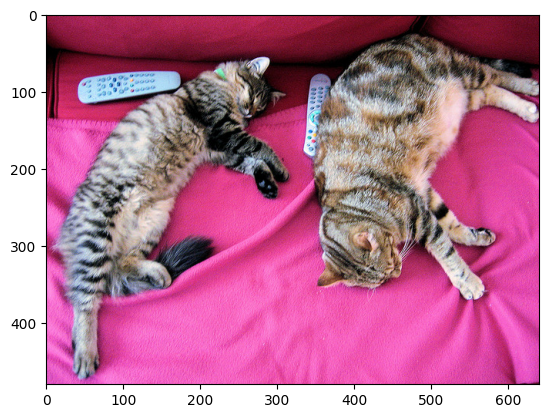

In [ ]:
import matplotlib.pyplot as plt 
plt.imshow(image)

In [ ]:
att_maps = outputs.vision_model_output.last_hidden_state.detach()
txt_state = outputs.text_model_output.last_hidden_state.detach()

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(att_maps[0, 1:, 200].reshape(14,14))
plt.colorbar()

NameError: name 'att_maps' is not defined

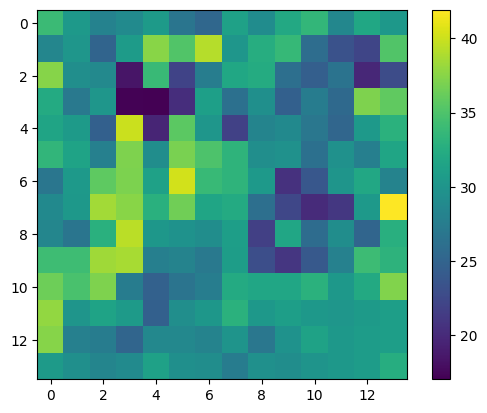

In [ ]:
sim_att_map = (att_maps[0, 1:,:] * att_maps[0, 0:1,:]).sum(-1)
plt.imshow(sim_att_map.reshape(14,14))
plt.colorbar()

In [ ]:
visual_projection = model.visual_projection
text_projection = model.text_projection

In [ ]:
vis_proj = visual_projection(att_maps)
txt_proj = text_projection(txt_state)

In [ ]:
vis_vector = vis_proj[:,1:,:] * model.logit_scale
txt_vector = txt_proj[:,-2:-1,:] * model.logit_scale

In [ ]:
txt_vector.shape

torch.Size([2, 1, 512])

In [ ]:
vis_vector.shape

torch.Size([1, 196, 512])

In [ ]:
res = (txt_vector * vis_vector).sum(-1)

In [ ]:
res.shape

torch.Size([2, 196])

In [ ]:
res.sum(-1)

tensor([  3001.2690, -10678.4121], grad_fn=<SumBackward1>)

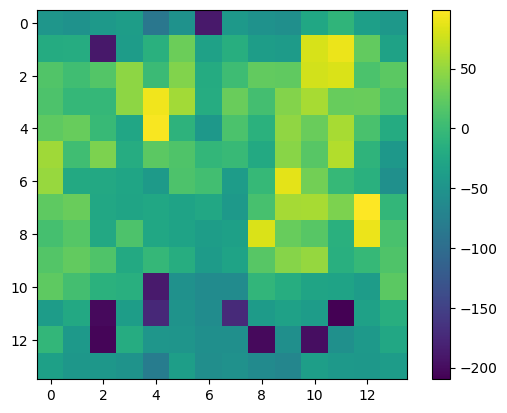

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(-res[0].detach().numpy().reshape(14,14))
plt.colorbar()

In [ ]:
vis_vector = vis_proj[:,0:1,:] * model.logit_scale
txt_vector = txt_proj[:,0:1,:] * model.logit_scale

In [ ]:
print(vis_vector.shape)
print(txt_vector.shape)

torch.Size([1, 1, 512])
torch.Size([2, 1, 512])


In [ ]:
(vis_vector * txt_vector).sum(-1)

tensor([[-26.3549],
        [-26.3549]], grad_fn=<SumBackward1>)

In [ ]:
outputs.text_embeds

tensor([[ 0.0413, -0.0037,  0.0096,  ...,  0.0059, -0.0040,  0.0131],
        [ 0.0282, -0.0117,  0.0112,  ..., -0.0110,  0.0240,  0.0283]],
       grad_fn=<DivBackward0>)

In [ ]:
txt_state.shape

torch.Size([2, 7, 512])

In [ ]:
txt_state[:,0,:]

tensor([[ 0.0134,  0.0697,  0.0683,  ..., -0.3548,  0.1088, -0.3185],
        [ 0.0134,  0.0697,  0.0683,  ..., -0.3548,  0.1088, -0.3185]])

In [ ]:
outputs.vision_model_output[1].shape

torch.Size([1, 768])